In [2]:
!pip install pyfolio
!pip install gdown
!pip install quantstats

In [3]:
!pip install pandas==1.3.5

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime as dt

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
#RESOURCES
!gdown 'https://drive.google.com/uc?export=download&id=1K7T7D4pnz9189rRJhRj_OTvGaUS9kmfx'  #META
META=pd.read_csv('META_1d.csv', parse_dates=True, index_col='timestamp')
META.index.name='DateTime'
META['DateTime'] = pd.to_datetime(META.index, unit='ms')
META['DateTime'] = META['DateTime'].dt.date


Downloading...
From: https://drive.google.com/uc?export=download&id=1K7T7D4pnz9189rRJhRj_OTvGaUS9kmfx
To: /content/META_1d.csv
100% 34.4k/34.4k [00:00<00:00, 43.2MB/s]


In [6]:
def clean_data(df):
    df.index = pd.to_datetime(df.index)
    df.index = pd.to_datetime(df['DateTime'])
    df.index = df.index.tz_localize(None)
    df = df[~df.index.duplicated(keep='first')]
    return df
META = clean_data(META)

In [7]:
print(META.head())

               open   high     low  close    volume    DateTime
DateTime                                                       
2021-06-30  15.0800  15.19  15.042  15.12  334935.0  2021-06-30
2021-07-01  15.1300  15.13  14.840  14.89  241629.0  2021-07-01
2021-07-02  15.0200  15.10  14.930  15.00  388152.0  2021-07-02
2021-07-06  15.0800  15.09  14.870  15.01  685094.0  2021-07-06
2021-07-07  15.0601  15.15  14.840  14.89  362538.0  2021-07-07


In [8]:
def bollinger_volume(prices, volume, window=20, num_std=2):
    sma = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)

    buy_signal = (prices < lower_band).astype(int)
    sell_signal = (prices > upper_band).astype(int)

    volume_adjusted = volume.rolling(window).mean().shift(1)
    return (buy_signal - sell_signal) * volume_adjusted


In [9]:
def skew_kurt_mean_reversion(prices, window=20):
    rolling_mean = prices.rolling(window).mean()
    rolling_std = prices.rolling(window).std()
    rolling_skew = prices.rolling(window).skew().shift(1)
    rolling_kurt = prices.rolling(window).kurt().shift(1)
    mean_reversion = (prices - rolling_mean) / rolling_std
    return mean_reversion * (rolling_skew + rolling_kurt)


In [10]:
def macd_divergence(prices, short_window=12, long_window=26, signal_window=9):
    ema_short = prices.ewm(span=short_window).mean()
    ema_long = prices.ewm(span=long_window).mean()

    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_window).mean()

    return macd - signal


In [11]:
def volatility_squeeze(prices, window=20, squeeze_window=100):
    rolling_std = prices.rolling(window).std()
    squeeze = (rolling_std / prices.rolling(squeeze_window).mean())

    breakout = prices.pct_change(window).shift(1) * squeeze.shift(1)

    return breakout


In [12]:
def momentum(prices, window=20):
    return prices.pct_change(window).shift(1)
def mean_reversion(prices, window=5):
    return -prices.pct_change(window).shift(1)
def volatility(prices, window=20):
    return -prices.rolling(window).std()
def liquidity(volume, window=20):
    return volume.rolling(window).mean()


In [13]:
def ensemble(prices, volume, window=20):
    momentums = momentum(prices, window)
    mean_revs = mean_reversion(prices, window)
    volatilitys = volatility(prices, window)
    liquiditys = liquidity(volume, window)

    combined_alpha = (momentums.rank(pct=True) + mean_revs.rank(pct=True) +
                      volatilitys.rank(pct=True) + liquiditys.rank(pct=True)) / 4

    return combined_alpha


In [14]:
def risk_adjusted_momentum(prices, window=20, volatility_window=60):
    momentum = prices.pct_change(window).shift(1)
    volatility = prices.rolling(volatility_window).std().shift(1)
    return momentum / volatility


In [15]:
def multi_momentum(prices):
  Short_Term_Momentum= prices.pct_change(5)
  Medium_Term_Momentum = prices.pct_change(20)
  Long_Term_Momentum = prices.pct_change(50)

  Multi_TF_Signal = np.where((Short_Term_Momentum > 0) &
                                  (Medium_Term_Momentum > 0) &
                                  (Long_Term_Momentum > 0), 1, -1)
  return Multi_TF_Signal

In [16]:
def combined_alpha(prices, volume, alpha_weights=None, window=20):
    bollingervolume = bollinger_volume(prices, volume)
    meanrev = skew_kurt_mean_reversion(prices)
    macddivergence = macd_divergence(prices)
    volatilitysqueeze = volatility_squeeze(prices)
    ensembles = ensemble(prices, volume)
    adjustedmomentum = risk_adjusted_momentum(prices)
    multimomentum = multi_momentum(prices)

    scaler = MinMaxScaler(feature_range=(-1, 1))

    signals=pd.DataFrame({
        'bollinger_volume': bollingervolume,
        'mean_rev': meanrev,
        'macd_divergence': macddivergence,
        'volatility_squeeze': volatilitysqueeze,
        'ensemble': ensembles,
        'adjusted_momentum': adjustedmomentum,
        'multi_momentum': multimomentum
    })
    signals_norm= pd.DataFrame(scaler.fit_transform(signals), columns=signals.columns, index=signals.index)

    if alpha_weights is None:
        alpha_weights={
            'bollinger_volume':0.1428,
            'mean_rev':0.1428,
            'macd_divergence':0.1428,
            'volatility_squeeze':0.1428,
            'ensemble':0.1428,
            'adjusted_momentum':0.1428,
            'multi_momentum':0.1432
        }

    combined = (alpha_weights['bollinger_volume']*signals['bollinger_volume'])+(alpha_weights['mean_rev']*signals['mean_rev'])+(alpha_weights['macd_divergence']*signals['macd_divergence'])+(alpha_weights['volatility_squeeze']*signals['volatility_squeeze'])+(alpha_weights['ensemble']*signals['ensemble'])+(alpha_weights['adjusted_momentum']*signals['adjusted_momentum'])+(alpha_weights['multi_momentum']*signals['multi_momentum'])

    return combined


In [17]:
class Backtester:
    def __init__(self, prices, volumes, alpha_function, initial_capital=100000, transaction_cost=0.001):
        self.prices = prices
        self.volumes = volumes
        self.alpha_function = alpha_function
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.positions = pd.DataFrame(0, index=prices.index, columns=prices.columns if isinstance(prices, pd.DataFrame) else [prices.name])
        self.cash = initial_capital
        self.portfolio_value = pd.Series(index=prices.index)

    def generate_signals(self):
        return self.alpha_function(self.prices, self.volumes)

    def run_backtest(self):
        signals = self.generate_signals()
        for t in range(1, len(self.prices)):
            buy_signals = signals.iloc[t] > 0
            sell_signals = signals.iloc[t] < 0

            self.positions.iloc[t] = np.where(buy_signals, 1, np.where(sell_signals, -1, self.positions.iloc[t-1]))
            trans_costs = np.abs(self.positions.iloc[t] - self.positions.iloc[t-1]) * self.prices.iloc[t] * self.transaction_cost

            daily_returns = self.positions.iloc[t] * self.prices.pct_change().iloc[t]
            self.cash -= trans_costs.sum()
            self.portfolio_value.iloc[t] = self.cash + (self.positions.iloc[t] * self.prices.iloc[t]).sum()

    def evaluate_performance(self):
        valid_portfolio_value = self.portfolio_value.dropna()
        print(valid_portfolio_value)
        returns = valid_portfolio_value.pct_change().fillna(0)
        returns_std = np.std(returns)
        if returns_std == 0 or np.isnan(returns_std) or np.isnan(np.mean(returns)):
          sharpe_ratio = np.nan
        else:
          sharpe_ratio = np.mean(returns) / returns_std
        max_drawdown = np.max(np.maximum.accumulate(valid_portfolio_value) - valid_portfolio_value) / np.maximum.accumulate(valid_portfolio_value)
        cumulative_return = (valid_portfolio_value.iloc[-1] - self.initial_capital) / self.initial_capital

        print(f"Sharpe Ratio: {sharpe_ratio}")
        print(f"Max Drawdown: {max_drawdown}")
        print(f"Cumulative Return: {cumulative_return}")


In [18]:
signals=combined_alpha(prices=META['close'], volume=META['volume'])
print(signals)

DateTime
2021-06-30             NaN
2021-07-01             NaN
2021-07-02             NaN
2021-07-06             NaN
2021-07-07             NaN
                  ...     
2024-06-04    2.513284e-02
2024-06-05   -1.627675e+06
2024-06-06   -1.644521e+06
2024-06-07    1.073041e+00
2024-06-10   -1.634534e+06
Length: 651, dtype: float64


In [19]:
df_meta = pd.DataFrame({
    'Close': META['close'],
    'Volume': META['volume']
})
bt = Backtester(prices=df_meta['Close'], volumes=df_meta['Volume'], alpha_function=combined_alpha)
bt.run_backtest()
bt.evaluate_performance()

<ipython-input-17-1b79debdc915>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.portfolio_value = pd.Series(index=prices.index)


DateTime
2021-07-01    100000.00000
2021-07-02    100000.00000
2021-07-06    100000.00000
2021-07-07    100000.00000
2021-07-08    100000.00000
                  ...     
2024-06-04    100416.97662
2024-06-05     99443.93650
2024-06-06     99445.23650
2024-06-07    100430.97058
2024-06-10     99434.40538
Length: 650, dtype: float64
Sharpe Ratio: -0.002107690293690233
Max Drawdown: DateTime
2021-07-01    0.010362
2021-07-02    0.010362
2021-07-06    0.010362
2021-07-07    0.010362
2021-07-08    0.010362
                ...   
2024-06-04    0.010314
2024-06-05    0.010314
2024-06-06    0.010314
2024-06-07    0.010314
2024-06-10    0.010314
Length: 650, dtype: float64
Cumulative Return: -0.005655946199999744


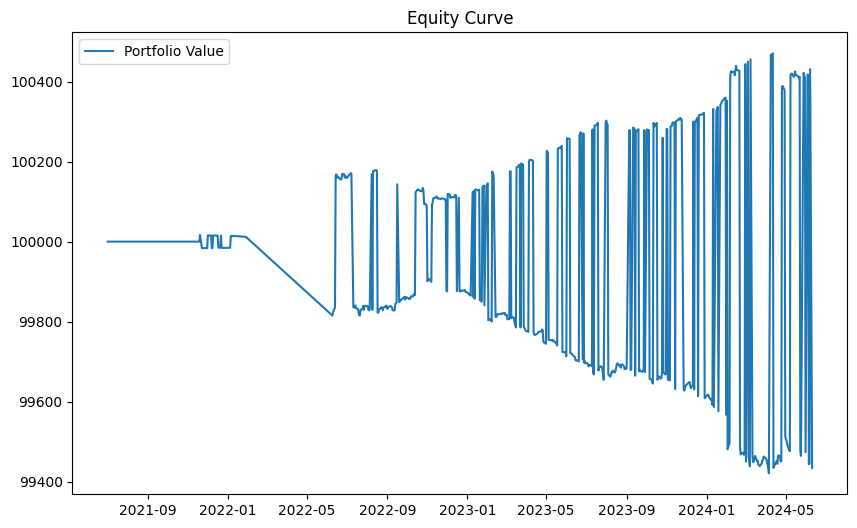

In [20]:
plt.figure(figsize=(10,6))
plt.plot(bt.portfolio_value, label='Portfolio Value')
plt.title('Equity Curve')
plt.legend()
plt.show()


In [21]:
returns = bt.portfolio_value.pct_change()
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

rolling_max = bt.portfolio_value.cummax()
drawdown = bt.portfolio_value / rolling_max - 1
max_drawdown = drawdown.min()

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

Sharpe Ratio: -0.0335
Maximum Drawdown: -0.0103


In [22]:
returns = bt.portfolio_value.pct_change().dropna()
returns.index = pd.to_datetime(returns.index, errors='coerce')
returns = returns[returns.index.notnull()]
#pf.create_full_tear_sheet(returns)

             close  alpha_combined  signal
DateTime                                  
2024-06-04  476.99        0.297558       1
2024-06-05  495.06        0.617455       1
2024-06-06  493.76        0.322875       1
2024-06-07  492.96        0.322389       1
2024-06-10  502.60        0.321035       1


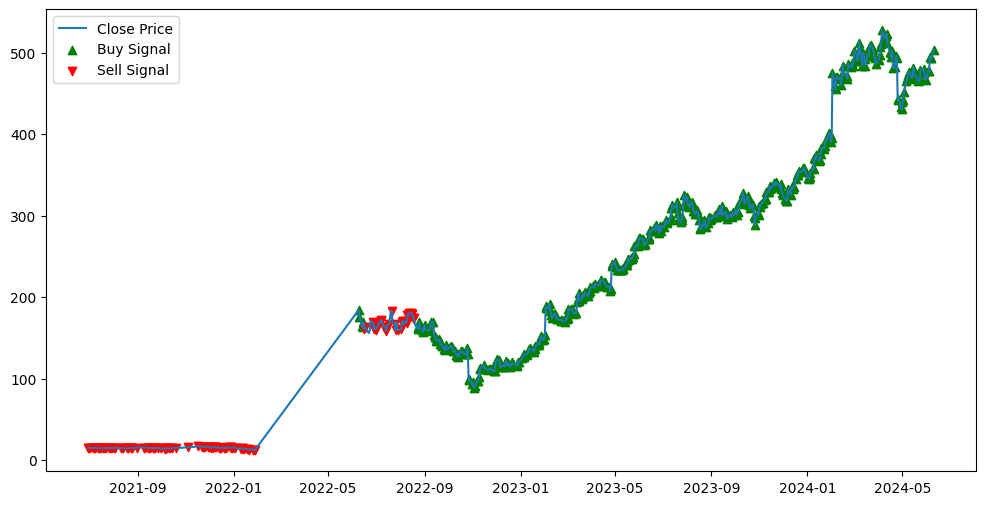

In [24]:
# trial with simple alphas
import numpy as np
import pandas as pd

META['alpha_1'] = META['close'].pct_change(5)

META['MA_50'] = META['close'].rolling(window=50).mean()
META['MA_200'] = META['close'].rolling(window=200).mean()
META['alpha_2'] = np.where(META['MA_50'] > META['MA_200'], 1, -1)

META['alpha_3'] = (META['volume'].pct_change(5) > 0.2).astype(int)

META['alpha_combined'] = (0.4 * META['alpha_1'].fillna(0) +
                                0.3 * META['alpha_2'] +
                                0.3 * META['alpha_3'])

buy_threshold = 0.2
sell_threshold = -0.2

META['signal'] = np.where(META['alpha_combined'] > buy_threshold, 1, 0)  # Buy signal
META['signal'] = np.where(META['alpha_combined'] < sell_threshold, -1, META['signal'])  # Sell signal

print(META[['close', 'alpha_combined', 'signal']].tail())

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(META.index, META['close'], label='Close Price')
plt.scatter(META.index[META['signal'] == 1], META['close'][META['signal'] == 1], label='Buy Signal', marker='^', color='g', alpha=1)
plt.scatter(META.index[META['signal'] == -1], META['close'][META['signal'] == -1], label='Sell Signal', marker='v', color='r', alpha=1)
plt.legend(loc='best')
plt.show()